# Exercise Lecture "15: Neural Sequence Tagging"

In this assignement, we learn a model which can detect noun phrases referring to visual entities given the Flicker30k entities corpus as training data.

In this corpus, each word is labelled with either (B) if that word starts an NP, (I) if it occurs within an NP and (O) otherwise. There is one word and one label per line. Sentences are separated by blank lines. 

Data file:  f30kE-captions-bio.txt 

## Pre-processing

#### Exercise 1 - Creating a list of lists of tokens (one list per sentence) and the corresponding lists of labels

* From the input file, create two lists called "texts" and "labels"
* "text" is a list of lists, each list containing the tokens of a sentence
* "labels" contains the list of lists of labels for each sentence in "text"

In [2]:
data_dir = "f30kE-captions-bio/f30kE-captions-bio.txt"
data = open(data_dir, "r").read()

In [1]:
cd ..

C:\experiments\cours nlp\data science\lecture15


In [3]:
text = []
labels = []
sent_token = []
sent_lab = []
for line in data.split('\n'):
    if line:
        token, label = line[:-2], line[-1]
        sent_token.append(token)
        sent_lab.append(label)
    else:
        assert len(sent_token) == len(sent_lab)
        assert len(set(sent_lab)) <= 3
        text.append(sent_token) 
        labels.append(sent_lab)
        sent_token, sent_lab = [], []
assert len(text) == len(labels)
len(text), len(labels)

(5501, 5501)

#### Exercise 2 -  Mapping labels to integers and sequence of labels to sequence of integers

* Create a dictionary label2int which maps each label to a distinct integer
* Apply this dictionary to the list of labels extracted in the previous exercise 

**Hint:** We did this in the preceding lab session.

In [4]:
from collections import defaultdict
label2int = defaultdict(lambda: len(label2int))
label2int['<eos>'] = 0
for labl in ['I', 'O', 'B']:
    [label2int[label] for label in ['I', 'O', 'B']]

In [5]:
#all_token = set([l.lower() for t in text for l in t])
token2int = defaultdict(lambda: len(token2int))
token2int['<eos>'] = 0
for l in text:
    [token2int[token.lower()] for token in l]

In [6]:
text_int = []
for sent in text:
    to_add = 16-len(sent)
    sent += ['<eos>']*to_add
    text_int.append(sent)
text_int = [[token2int[token.lower()] for token in l] for l in text]

In [7]:
label_int=[]
for label in labels:
    to_add = 16-len(label)
    label += ['<eos>']*to_add
    label_int.append(label)
label_int = [[label2int[token] for token in l] for l in labels]

#### Exercise 3 - Convert the tokens to integers

* Similarly define a token2int dictionary mapping each token in your corpus to an integer and use this dictionary to convert the texts in the list "texts" (cf. Exercise 1.1) into lists of integers, each integer representing a token

* **IMPORTANT** make sure to lowercase the tokens as the pre-trained embeddings we'll be using only include lowercased tokens. 

In [14]:
def lower_int(tokens):
    t_int = []
    for t in tokens:
        tl = t.lower()
        token2int[tl]
        t_int.append(token2int[tl])
    return t_int

#### Exercise 4 - Create the reverse dictionaries (int2label, int2token) to map integer labels and integer tokens back to labels and tokens 

This is useful to be able to inspect results later on.

In [8]:
int2label = { k : v for v, k in label2int.items()}
int2token = { k : v for v, k in token2int.items()}

## Creating training and validation data

##### Pytorch import and key constants (PROVIDED)

- `max_len` is the maximum sentence length
- `batch_size` is the batch size
- `embed_size` is the size of the pre-trained embeddings (word vectors). We use fasttext pre-trained embeddings of size 300.
- `hidden_size` is the size of the RNN hidden state

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

max_len = 16
batch_size = 64
embed_size = 300
hidden_size = 128

#### Exercise 2.1  - Creating tensors

To work with pytorch, all data must be converted to tensors. 

* X and Y are tensors of integers of size (number of sentences, max sentence length) initialised with 0 (this is the value of the padding symbol)
* For each x and y, compute the length and cut down any instance that is over the max sentence length to that length
* We populate the zeros tensors with the input data from exercise 1.1

**Hint:** You did this in the previous lab session

In [10]:
X = torch.tensor(text_int)

In [11]:
y = torch.tensor(label_int)

#### Exercise  6 - Create train and validation data

* Split X into two parts, one called X_train which consists of the first 5000 items and the other called X_valid which includes the rest of the data
* Do the same for Y

In [12]:
X_train = X[:5000,:]
X_test = X[5000:,:]
y_train = y[:5000,:]
y_test = y[5000:,:]

#### Exercise  7 - Use torch DataLoader to split training and validation data into batches

**Hint:** This was provided in the previous lab sessions

In [13]:
from torch.utils.data import TensorDataset, DataLoader
# the TensorDataset is a ready to use class to represent your data as list of tensors. 
# Note that input_features and labels must match on the length of the first dimension
train_set = TensorDataset(X_train, y_train)
valid_set = TensorDataset(X_test, y_test)

# DataLoader shuffles and batches the data and load its in parallel using multiprocessing workers

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size)

## Using pre-trained Fasttext embeddings

Instead of learning word embeddings using the network, we use pre-trained Fasttext embeddings. These are available [here](https://fasttext.cc/docs/en/english-vectors.html).

However these cover several millions words and the files are large. Instead we'll use a smaller version which is restricted to the corpus vocabulary and is available on arche (wiki.en.filtered.vec). Each line in that file contains a token followed by the Fasttext embedding of that token(300 dimensions). 
E.g., auditorium -0.054196 -0.37375 ....

#### Exercise 8
To use the pre-trained embeddings, we do the following:

* first, we create a tensor of size (vocab_size, embedding_size) with embedding_size = 300 and values 0 (use torch.zeros method)

* we store each line in wiki.en.filtered.vec  into a list "tokens" whose first element is the word and the second the pretrained fasttext emebdding

* If the word is in our vocabulary we set the corresponding index (use your token2int dictionary) in our 0 tensor to the corresponding fasttext embedding. 

**N.B.** fasttext embeddings elements needs to be converted to float so you'll need to do something like

torch.FloatTensor([float(x) for x in FSEmbedding])

when setting the word index in the tensor to the fasttext embeddng

In [14]:
vect = open("wiki.en.filtered/wiki.en.filtered.vec").readlines()

In [15]:
vocab_size = len(token2int)
embeddings = torch.zeros(vocab_size, embed_size)
tokens = []
for line in vect: # Pour chaque liste
        token = line.split(' ')[0] # On lit le token et son embedding
        embed = line.split(' ')[1:]
        tokens.append((token, embed)) # On les ajoute à la liste
        
        if token in token2int.keys(): # Si le token est dans le vocabulaire
            embeddings[token2int[token]] = torch.FloatTensor([float(x) for x in embed]) # On le met dans le tensor

## Create, train and evaluate your neural network

#### Exercise  9 - Define your neural network (TODO: Provide missing values indicated by ??)

As in the preceding Exercise sheet on neural classification, we define our RNN network as a subclass of pytorch RNN module. 

Our RNN consist of three layers:
* the embedding layer: wich maps each token in the input to its fasttext embedding
* A GRU layer: the recurrent layers
* A decision layer which maps each input token to a label

##### Padding
If the input sentence is shorter than the maximum length, the remaining positions are filled with 0, the integer associated with the padding symbol. To exclude padding symbols  from the learning process (they are uninformative), include the padding_idx=vocab['<eos>'] option in the definition of the embedding layer and the 
"bias=False" option in the definition of the GRU layer. This forces the GRU hidden state to be null for all padding symbols. 
    
##### Pre-trained Embeddings
To ensure that the pretrained word embeddings are used:
* set the `weight` attribute of the embedding layer to the pretrained embeddings
* Use `requires_grad=False` to freeze the embedding layer so that the fasttext embeddings are not modified during learning.   
If you do not use this option the embeddings are fine tuned during training. 

In [16]:
class RNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size, padding_idx=token2int['<eos>'])
        self.embed.weight = nn.Parameter(embeddings, requires_grad=False)
        self.rnn = nn.GRU(embed_size, hidden_size, bias=False, num_layers=1, 
                          bidirectional=False, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.decision = nn.Linear(hidden_size * 1 * 1, len(label2int))
        
    def forward(self, x):
        embed = self.embed(x)
        output, hidden = self.rnn(embed)
        return self.decision(self.dropout(output))

rnn_model = RNN()
rnn_model

RNN(
  (embed): Embedding(4596, 300, padding_idx=0)
  (rnn): GRU(300, 128, bias=False, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (decision): Linear(in_features=128, out_features=4, bias=True)
)

#### Define a function to evaluate the performance of the model (PROVIDED)

* the CrossEntropyLoss takes as input 2D matrices of shape (batch_size * sequence_length, num_labels)
* Scores shape is adjusted accordingly
* References are reshaped to (batch_size * sequence_length).
* the max used to compute predictions applies to the last dimension of the y_scores tensors
* To ignore padding symbols when computing the score, we create a matrix "mask" which contains 1 for all non nul elements of the Y matrix and O otherwise

In [17]:
def perf(model, loader):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    total_loss = correct = num_loss = num_perf = 0
    for x, y in loader:
      with torch.no_grad():
        y_scores = model(x)
        loss = criterion(y_scores.view(y.size(0) * y.size(1), -1), y.view(y.size(0) * y.size(1)))
        y_pred = torch.max(y_scores, 2)[1]
        mask = (y != 0)
        correct += torch.sum((y_pred.data == y) * mask)
        total_loss += loss.item()
        num_loss += len(y)
        num_perf += torch.sum(mask).item()
    return total_loss / num_loss, correct.item() / num_perf

perf(rnn_model, valid_loader)

(0.02202503124396958, 0.34460887949260044)

#### Exercise 10 - Define the training function

## Apply your model to a sentence

Accuracy scores might be deceiving. We also need to look at the predictions on some example sentences. 

In [18]:
def fit(model, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        num_samples = 0
        
        for x_data, y_data in train_loader:
            x_data = x_data.to(device)
            y_data = y_data.to(device)
            optimizer.zero_grad()
            y_scores = model(x_data)
            loss = criterion(y_scores.transpose(1, 2), y_data) # Modifications faites ici
            num_samples += len(y_data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        valid_loss, valid_acc = perf(model, valid_loader)
        print(f'Epoch {epoch + 1}/{epochs} | Train loss: {total_loss/num_samples:.4f} | Valid loss: {valid_loss:.4f} | Acc: {valid_acc:.4%}')

In [19]:
device = torch.device('cpu')
fit(rnn_model, 15)

Epoch 1/15 | Train loss: 0.0080 | Valid loss: 0.0023 | Acc: 93.2699%
Epoch 2/15 | Train loss: 0.0015 | Valid loss: 0.0014 | Acc: 96.0712%
Epoch 3/15 | Train loss: 0.0010 | Valid loss: 0.0013 | Acc: 96.5469%
Epoch 4/15 | Train loss: 0.0008 | Valid loss: 0.0011 | Acc: 97.0402%
Epoch 5/15 | Train loss: 0.0008 | Valid loss: 0.0011 | Acc: 97.1635%
Epoch 6/15 | Train loss: 0.0007 | Valid loss: 0.0011 | Acc: 97.1459%
Epoch 7/15 | Train loss: 0.0006 | Valid loss: 0.0010 | Acc: 97.4278%
Epoch 8/15 | Train loss: 0.0006 | Valid loss: 0.0010 | Acc: 97.3397%
Epoch 9/15 | Train loss: 0.0005 | Valid loss: 0.0010 | Acc: 97.4278%
Epoch 10/15 | Train loss: 0.0005 | Valid loss: 0.0010 | Acc: 97.6039%
Epoch 11/15 | Train loss: 0.0004 | Valid loss: 0.0010 | Acc: 97.5687%
Epoch 12/15 | Train loss: 0.0004 | Valid loss: 0.0010 | Acc: 97.6568%
Epoch 13/15 | Train loss: 0.0004 | Valid loss: 0.0010 | Acc: 97.6568%
Epoch 14/15 | Train loss: 0.0004 | Valid loss: 0.0010 | Acc: 97.6216%
Epoch 15/15 | Train loss: 0.0

#### Exercise 11 Apply your model to a sentence

We define a `tag_sentence` function which:

* takes a input the learned model and a sentence identifier i
* retrieves from the data tensor X_valid the tensor for the i-th sentence (call it "sentence")
* retrieves from the data tensor Y_valid the tensor of labels for the i-th sentence 
* put the model into evaluation mode
* execute the model on the sentence tensor ("sentence")
* extract the top predictions (use argmax)
* print out the list of predicted tags 
   - use t.item() to get a value out of a tensor
   - use your dictionary int2label to print out the results

In [44]:
def tag_sentence(model, X_test):
     #int2label[3] = 'B'
    #sentence = X_test[i]
    sentence = X_test
    #labels = y_test[i]
    model.eval()
    y_scores = model(sentence)
    y_pred = y_scores.argmax(2) # On choisit la classe avec les scores les plus élevés
    #print('TOKEN'.ljust(10), 'PRED'.ljust(5), 'TRUE')
    #print('-'*20)
    #for j, pred in enumerate(y_pred):
        #print(
              #int2token[sentence[j].item()].ljust(10),
              #int2label[pred.item()].ljust(5),
              #int2label[labels[j].item()]
        #)
    return y_pred

In [45]:
x = tag_sentence(rnn_model, X_test)

In [71]:
pred_label = [[int2label[pred] for pred in l] for l in x.tolist()]
true_label =  [[int2label[pred] for pred in l]for l in y_test.tolist()]

In [ ]:
pip install seqeval

In [73]:
from seqeval.metrics import classification_report
print(classification_report(true_label, pred_label))

              precision    recall  f1-score   support

           _       0.91      0.93      0.92      1490
        eos>       0.98      1.00      0.99       465

   micro avg       0.92      0.95      0.94      1955
   macro avg       0.94      0.96      0.95      1955
weighted avg       0.92      0.95      0.94      1955



In [77]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()


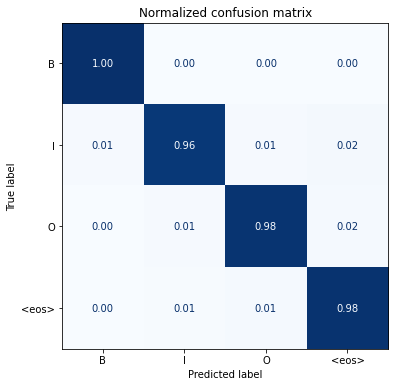

In [78]:
pred_y = [int2label[pred] for pred in x.flatten().tolist()]
true_y = [int2label[pred] for pred in y_test.flatten().tolist()]
plot_confusion_matrix(true_y, pred_y, ['B','I','O','<eos>'])